# Lasso Random CV Initial

## Preprocess Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('../'))

from Models.DecisionTreeRegressor import DecisionTreeRegressor
from Utils.Preprocessor import Preprocessor
from Utils.Utils import root_mean_squared_error, train_test_split, initial_preprocessing, feature_elimination
from Utils.CrossValidation import KFoldCrossValidation
from Utils.Pipeline import Pipeline

In [2]:
# Read the data
train = pd.read_csv('../Data/train.csv', index_col='Id')
# Remove unnecessary features based on exploratory data analysis part 1.
train = initial_preprocessing(train)
train = feature_elimination(train)
X = train.drop(columns=["num_wins_agent1", "num_draws_agent1", "num_losses_agent1", "utility_agent1"], axis=1)
y = train["utility_agent1"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# clip the dataset
X_train = X_train[0:10000]
y_train = y_train[0:10000]

## Randomized CV

In [3]:
# Randomized Cross Validation
num_folds = 5
num_iterations = 20

# uniform max_depth range
max_depth_range = np.arange(2, 7)
min_samples_split_percentage_range = np.linspace(0.01, 0.1, 10)
results = []

for i in range(num_iterations):
    max_depth = np.random.choice(max_depth_range).astype(int)
    min_samples_split_percentage = np.random.choice(min_samples_split_percentage_range)

    pipeline = Pipeline(Preprocessor(normalize=True, standardize=False, one_hot_encode=True), DecisionTreeRegressor(max_depth=max_depth, min_samples_split=X.shape[0] * min_samples_split_percentage))
    print(f"Iteration {i+1} / {num_iterations} - Max Depth: {max_depth}, Min Samples Split Percentage: {min_samples_split_percentage}")

    cross_val = KFoldCrossValidation(pipeline, X_train, y_train, num_folds)
    mean_score = cross_val.mean_score()
    results.append(([max_depth, min_samples_split_percentage], mean_score))

    print(f"Finished iteration {i + 1}/{num_iterations}, score: {mean_score:.6f}")
    print()
sorted_results = sorted(results, key=lambda x: x[1])

print("Parameters | Score")
print("-" * 25)
for parameter, score in sorted_results:
    print(f"{parameter} | {score:.6f}")

best_params, best_score = sorted_results[0]
print(f"\nBest Params: {best_params}")
print(f"Best Score: {best_score:.6f}")

Iteration 1 / 20 - Max Depth: 6, Min Samples Split Percentage: 0.030000000000000006
Finished iteration 1/20, score: 0.557767

Iteration 2 / 20 - Max Depth: 3, Min Samples Split Percentage: 0.08
Finished iteration 2/20, score: 0.618204

Iteration 3 / 20 - Max Depth: 4, Min Samples Split Percentage: 0.06000000000000001
Finished iteration 3/20, score: 0.618204

Iteration 4 / 20 - Max Depth: 2, Min Samples Split Percentage: 0.08
Finished iteration 4/20, score: 0.618204

Iteration 5 / 20 - Max Depth: 5, Min Samples Split Percentage: 0.01
Finished iteration 5/20, score: 0.557946

Iteration 6 / 20 - Max Depth: 2, Min Samples Split Percentage: 0.07
Finished iteration 6/20, score: 0.618204

Iteration 7 / 20 - Max Depth: 5, Min Samples Split Percentage: 0.09000000000000001
Finished iteration 7/20, score: 0.618204

Iteration 8 / 20 - Max Depth: 2, Min Samples Split Percentage: 0.1
Finished iteration 8/20, score: 0.618204

Iteration 9 / 20 - Max Depth: 2, Min Samples Split Percentage: 0.0600000000

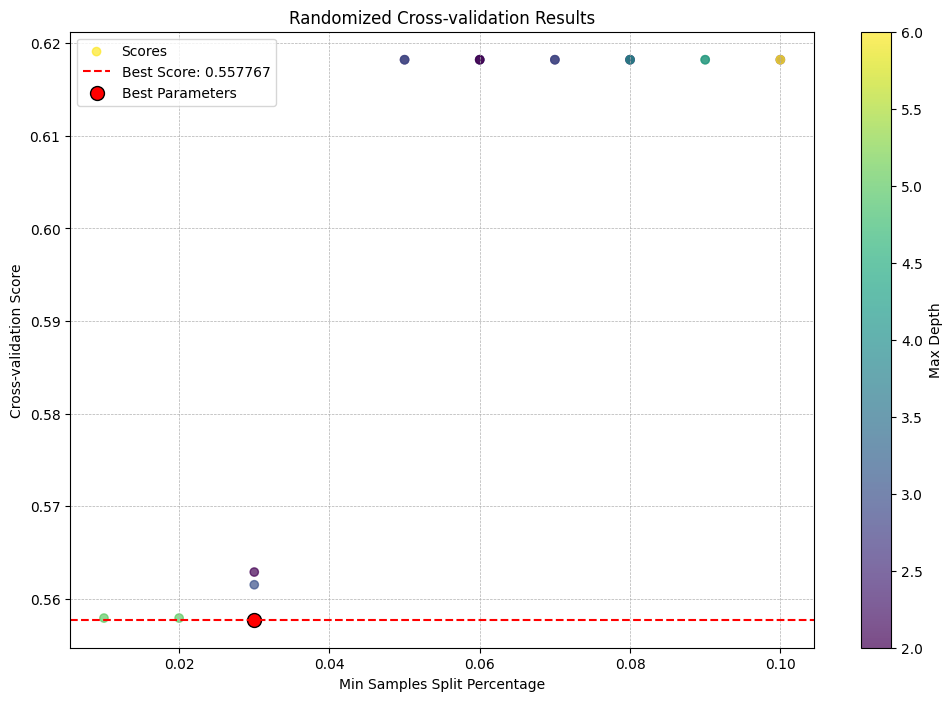

In [5]:
# Extract the parameters and scores from the results
parameters = [result[0] for result in results]
max_depth_values = [param[0] for param in parameters]
min_samples_split_values = [param[1] for param in parameters]
scores = [result[1] for result in results]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    min_samples_split_values, scores, c=max_depth_values, cmap='viridis', alpha=0.7, label='Scores'
)
cbar = plt.colorbar(scatter)
cbar.set_label('Max Depth')

plt.xlabel('Min Samples Split Percentage')
plt.ylabel('Cross-validation Score')
plt.title('Randomized Cross-validation Results')
plt.axhline(y=best_score, color='red', linestyle='--', label=f'Best Score: {best_score:.6f}')
plt.scatter(best_params[1], best_score, color='red', edgecolor='black', s=100, label='Best Parameters')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()
